In [1]:
import pandas as pd
# reading in data from the first protein
df = pd.read_csv("data/AF-O43526-F1-model_v3.tsv", sep='\t')
df

,index,x,y,z,gamma,exp,obs
0,1,-3.512,-33.674,-14.723,0.766105,0.551831,0
1,2,-1.390,-34.119,-11.579,0.286887,0.548329,0
2,3,1.629,-36.312,-11.147,0.535520,0.621959,2
3,4,4.865,-35.872,-9.157,0.688981,0.579143,1
4,5,7.371,-38.625,-8.349,0.442748,0.575410,0
...,...,...,...,...,...,...,...
867,868,-12.577,-52.381,-22.296,0.353039,0.586997,0
868,869,-10.479,-51.784,-19.900,0.380064,0.597300,0
869,870,-6.981,-50.668,-18.703,0.392629,0.529663,0
870,871,-3.920,-51.828,-16.712,0.431890,0.630496,0


In [2]:
import numpy as np

def upd_variance(x, n_mu_var):
    n, mu, var = n_mu_var
    dmu = (x - mu) / (n+1)
    nmu = mu + dmu
    nvar = 1/(n + (n == 0)) * ((n-1)*var + n*dmu**2 + (x - nmu)**2)
    return n+1, nmu, nvar

def subsegment_variances(A):
    # print(A)
    N = len(A)
    vars = np.zeros(shape=(N, N))
    means = np.zeros(shape=(N, N))
    for start in range(N):
        n, mu, var = 0, 0, 0
        for end in range(start, N):
            # print(n, mu, var)
            dmu = (A[end] - mu) / (n+1)
            nmu = mu + dmu
            nvar = 1/(n + (n == 0)) * ((n-1)*var + n*dmu**2 + (A[end] - nmu)**2)
            n, mu, var = n+1, nmu, nvar

            vars[start][end] = var
            means[start][end] = mu

    return vars, means


# subsegment_variances(np.array(range(5)))

In [4]:


x_vars, _ = subsegment_variances(df.x)
y_vars, _ = subsegment_variances(df.y)
z_vars, _ = subsegment_variances(df.z)
_, obs_means = subsegment_variances(df.obs)

sq_obs_means = obs_means**0.5

# generate pairwise distances
N = len(df)
dists = np.zeros(shape=(N, N))
for a in range(N):
    for b in range(a, N):
        dists[a][b] = (df.x[a]-df.x[b])**2 + (df.y[a]-df.y[b])**2 + (df.z[a]-df.z[b])**2



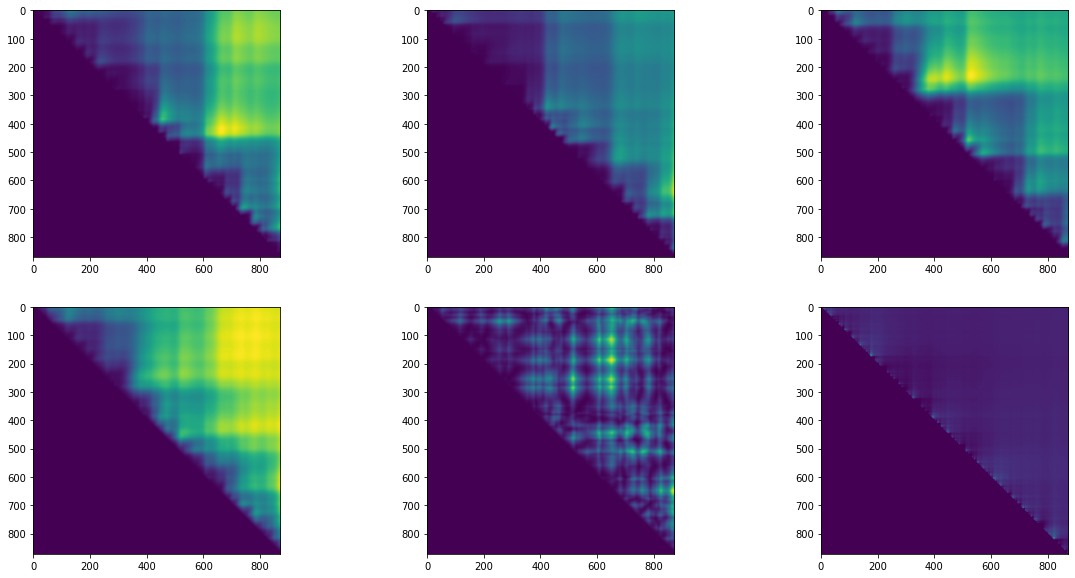

In [38]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]


domains = [(96, 318), (466,650)]



# plot
# fig, ax = plt.subplots(3, 4)
fig, ax = plt.subplots(2, 3)

ax[0][0].imshow(x_vars)
ax[0][1].imshow(y_vars)
ax[0][2].imshow(z_vars)
ax[1][0].imshow(x_vars + y_vars + z_vars)
ax[1][1].imshow(dists)
ax[1][2].imshow(obs_means)
# for i in range(2):
#     for j in range(3):
#         ax[i][j].plot([96, 318, 318, 466, 650, 650], [96, 96, 318, 466, 466, 640])

# ax[2][1].imshow(dists)




plt.show()

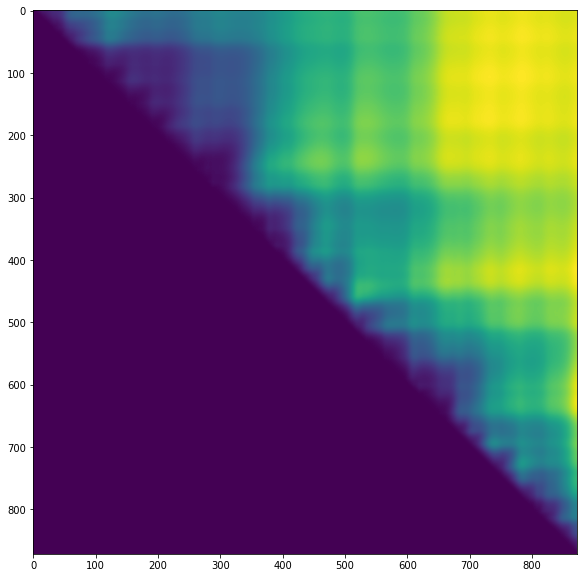

In [8]:
plt.imshow(x_vars + y_vars + z_vars)

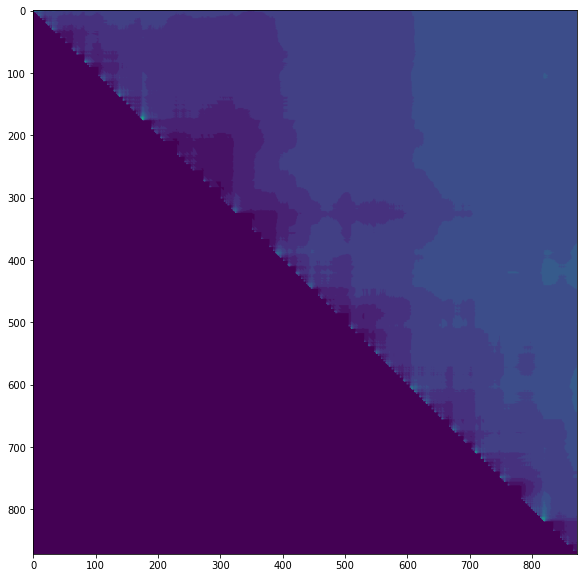

In [36]:
vars = x_vars + y_vars + z_vars
# print(obs_means)
# print(np.around(vars/vars.mean() + obs_means/obs_means.mean(), 1))
wavg = np.around(vars/vars.mean() + obs_means/obs_means.mean())
a = np.array([[max(0, i-j) for i in range(N)] for j in range(N)])
plt.imshow(wavg)

# Final answer is take the longest low-valued region and colour that differently to the rest

C:\Users\Laeeq\AppData\Local\Temp\ipykernel_14956\901226072.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(1/wavg)


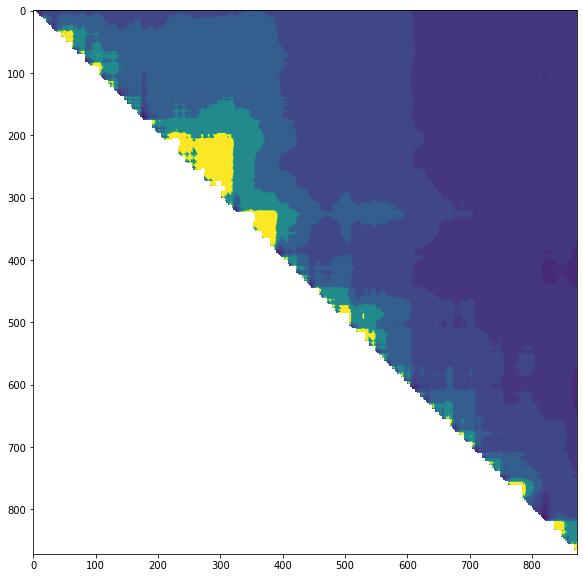

In [34]:
plt.imshow(1/wavg)

C:\Users\Laeeq\AppData\Local\Temp\ipykernel_14956\2088733990.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(np.sqrt(a)/wavg)
C:\Users\Laeeq\AppData\Local\Temp\ipykernel_14956\2088733990.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.sqrt(a)/wavg)


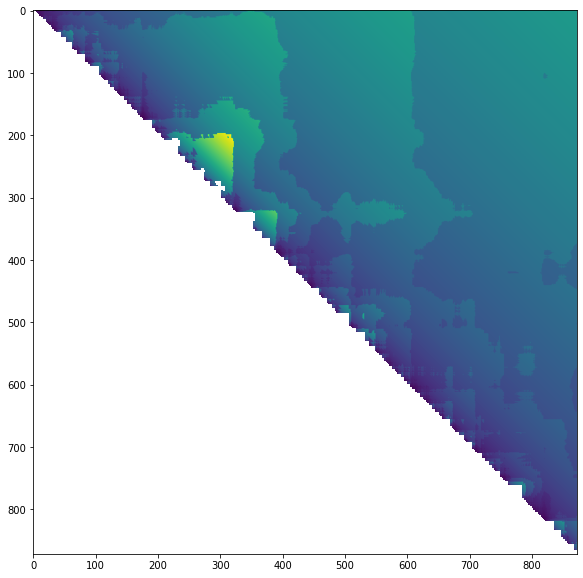

In [35]:
plt.imshow(np.sqrt(a)/wavg)

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

P01009 = pd.read_csv("data/AF-P01009-F1-model_v3.tsv", sep='\t')

# print(len(P01009))
# x_vars_P01009, _ = subsegment_variances(P01009.x)
# y_vars_P01009, _ = subsegment_variances(P01009.y)
# z_vars_P01009, _ = subsegment_variances(P01009.z)
# _, obs_means_P01009 = subsegment_variances(P01009.obs)

# # sq_obs_means = obs_means**0.5

# # generate pairwise distances
# N = len(P01009)
# dists_P01009 = np.zeros(shape=(N, N))
# for a in range(N):
#     for b in range(a, N):
#         dists_P01009[a][b] = (P01009.x[a]-P01009.x[b])**2 + (P01009.y[a]-P01009.y[b])**2 + (P01009.z[a]-P01009.z[b])**2



# domains = [(96, 318), (466,650)]



# # plot
# # fig, ax = plt.subplots(3, 4)
# fig, ax = plt.subplots(2, 3)

# ax[0][0].imshow(x_vars_P01009)
# ax[0][1].imshow(y_vars_P01009)
# ax[0][2].imshow(z_vars_P01009)
# # ax[0][3].imshow(obs_means)
# ax[1][0].imshow(x_vars_P01009 + y_vars_P01009 + z_vars_P01009)
# ax[1][1].imshow(dists_P01009)

# # ax[2][1].imshow(dists)




plt.show()

418


(array([ 69., 101.,  67.,  99.,  95.,  83.,  85.,  77.,  99.,  97.]),
 array([0.00967089, 0.10842501, 0.20717913, 0.30593324, 0.40468736,
        0.50344147, 0.60219559, 0.70094971, 0.79970382, 0.89845794,
        0.99721206]),
 <BarContainer object of 10 artists>)

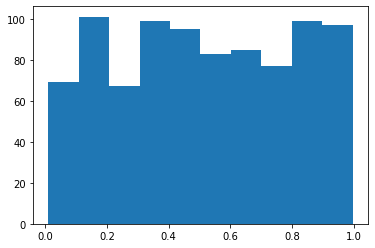

In [ ]:

plt.hist(data['gamma'])

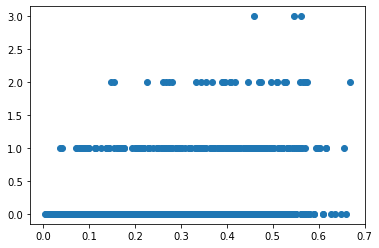

In [ ]:

plt.scatter(data.gamma*data.exp, data.obs)